# Costruzione di una rete sbilanciata elementare e calcolo delle tensioni di ogni fase considerando un profilo di carico 

### Costruzione della rete

In [1]:
from math import cos,sin,acos,pi
import numpy as np
import pandapower as pp
from funzioni_rete import *
import matplotlib.pyplot as plt
import pandapower.plotting as pplot
from pandapower.pf.runpp_3ph import runpp_3ph

Matrice di trasformata di Fortescue, è necessaria per passare la matrice di impedenze di una linea da abc a sequenza 012

In [2]:
A = np.array([  [1,1,1],
                [1, cos(4*pi/3)+ sin(4*pi/3)*1j, cos(2*pi/3)+sin(2*pi/3)*1j],
                [1, cos(2*pi/3)+ sin(2*pi/3)*1j, cos(4*pi/3)+sin(4*pi/3)*1j]])
invA = 1/3*np.array([[1,1,1],
                    [1, cos(2*pi/3)+ sin(2*pi/3)*1j, cos(4*pi/3)+sin(4*pi/3)*1j],
                    [1, cos(4*pi/3)+ sin(4*pi/3)*1j, cos(2*pi/3)+sin(2*pi/3)*1j]])

Costruzione della matrice di impedenze di una linea Zabc, è 3x3 perche è già stata fatta la riduzione di Kron

In [3]:
# Matrice di impedenze di fase -dopo Kron-  [ohm/mi]
Zabc = np.array([[.3375 + 1.0478j, .1535+.3849j, .1559+.5017j],[.1535+.3849j, .3414 +1.0348j, .1580+.4236j],[.1559+.5017j, .1580+.4236j, .3465+1.0179j]])
Zabc = 3*Zabc #linea lung 3 mi

# Sistemo Zabc per considerare la linea trasposta
Zabc[0,0] = Zabc[1,1] = Zabc[2,2] = (Zabc[0,0] + Zabc[1,1] + Zabc[2,2])/3
Zabc[0,1] = Zabc[0,2] = Zabc[1,2] = (Zabc[0,1] + Zabc[0,2] + Zabc[1,2])/3
Zabc[1,0] = Zabc[2,0] = Zabc[2,1] = Zabc[0,1]

In [4]:
Zabc

array([[1.0254+3.1005j, 0.4674+1.3102j, 0.4674+1.3102j],
       [0.4674+1.3102j, 1.0254+3.1005j, 0.4674+1.3102j],
       [0.4674+1.3102j, 0.4674+1.3102j, 1.0254+3.1005j]])

Si trasforma la matrice di impedenze Zabc in quella di impedenze 012 usando la trasformazione di Fortescue (matrici A e invA) 

In [5]:
#Matrice delle impedenze in sequenza 012
Z012 = invA@Zabc@A

In [6]:
Z012

array([[ 1.96020000e+00+5.72090000e+00j, -4.35108143e-16-1.97346723e-16j,
        -5.77496672e-16+3.00213106e-17j],
       [-4.99600361e-16-2.22044605e-16j,  5.58000000e-01+1.79030000e+00j,
        -4.99600361e-16+4.44089210e-16j],
       [-4.44089210e-16-2.22044605e-16j, -4.44089210e-16+5.55111512e-16j,
         5.58000000e-01+1.79030000e+00j]])

Da Z012 si ottengono i dati di resistenza e reattanza per ogni sequenza, quesi verrano utilizzati nella costruzione della rete in pandapower.

In [7]:
# Resistenza e reattanza in sequenza 012 (Z1 = Z2)
r0 = np.real(Z012[0,0])
x0 = np.imag(Z012[0,0])
c0 = 0
r1 = np.real(Z012[1,1])
x1 = np.imag(Z012[1,1])
c1 = 0

Dati del carico sbilanciato presente al nodo 1

In [8]:
# Potenza del carico trifase (MW y Mvar)
pa = 1.5*0.88
pb = 1*0.95
pc = 2*.8
qa = 1.5*sin(acos(.88))
qb = 1*sin(acos(0.95))
qc = 2*sin(acos(.8))

Avendo tutti i dati necessati si passa alla costruzione della rete in Pandapower.

In [9]:
#  ---- Costruzione rete Pandapower  ----  #
#Costruzione rete
net = pp.create_empty_network(f_hz=60)      
# Rete vuota
pp.create_bus(net, 12.47, 'bus0')           
# Aggiungo y nodi
pp.create_bus(net, 12.47, 'bus1')
# Rete esterna / nodo slack
pp.create_ext_grid(net, 0, 1, 0, s_sc_max_mva=1000000000, rx_max = 0.1, x0x_max = 0.1, r0x0_max=0.1) 
# Aggiungo la linea (Si crea una linea di 1km con dati corrispondenti a una linea di 3 miglia)
pp.create_line_from_parameters(net, 0, 1, 1, r1, x1, c1, 1000000, name = 'linea01'
    , r0_ohm_per_km= r0, x0_ohm_per_km= x0, c0_nf_per_km= c0)
# Aggiungo gli interruttori
pp.create_switch(net, bus = 0, element=0, et= 'l')
pp.create_switch(net, bus = 1, element=0, et= 'l')
# Aggiungo il carico trifase
pp.create_asymmetric_load(net=net, bus = 1, p_a_mw=pa, q_a_mvar=qa, sn_mva=1.5) 
pp.create_asymmetric_load(net=net, bus = 1, p_b_mw=pb, q_b_mvar=qb, sn_mva=1)
pp.create_asymmetric_load(net=net, bus = 1, p_c_mw=pc, q_c_mvar=qc, sn_mva=2)

2

Informazioni del numero di elementi nella rete

In [10]:
net

This pandapower network includes the following parameter tables:
   - bus (2 elements)
   - asymmetric_load (3 elements)
   - switch (2 elements)
   - ext_grid (1 element)
   - line (1 element)

Schema della rete appena creata

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


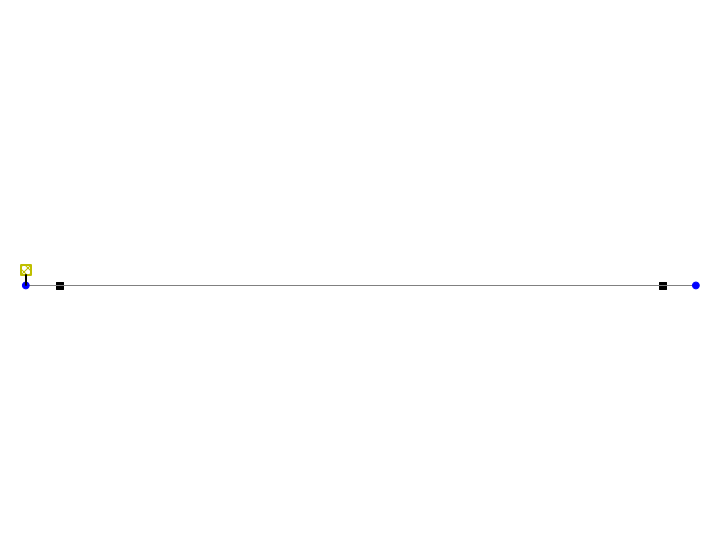

In [11]:
#  ---- Schema della rete ----  #
ax = pplot.simple_plot(net, show_plot=False)
sc = pplot.create_line_switch_collection(net, size = 0.01, distance_to_bus = 0.05)
pplot.draw_collections([sc], ax = ax)
plt.show()

### Carica dei profili di carico

Carica dei profili di carico, i dato vengono da un file .mat, per salvarli in un DataFrame si usa una funzione apposita presente nel file funzioni_rete.py

In [12]:
# --- Carica profili di carico --- #
profili_df = carica_profili_df('ReteRurale_profili.mat')

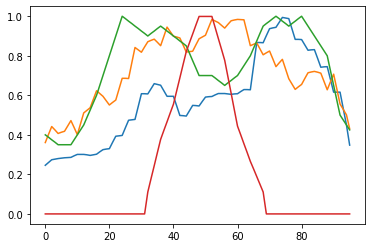

In [13]:
plt.plot(profili_df)
plt.show()

### Soluzione della rete considerando il profili di carico

Soluzione del sistema ad ogni intervallo di tempo, al carico sbilanciato del nodo 1 viene assegnato il profilo di carico industriale.

In [14]:
# --- Soluzione del sistema ad ogni intervallo di tempo  --- #
tre_df = net.res_bus_3ph.copy()
for i in range(96):
    net.asymmetric_load.scaling = profili_df.ind[i]
    runpp_3ph(net)
    tre_df = tre_df.append(net.res_bus_3ph.loc[1],ignore_index=True)

### Risultati delle tensioni di fase in pu

Costruzione del grafico che mostra l'evoluzione della tensione al nodo 1 per ogni fase.

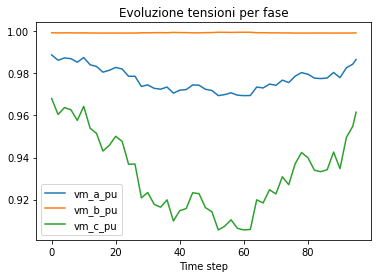

In [15]:
# --- Grafico --- #
evol_tens_df = tre_df[['vm_a_pu','vm_b_pu','vm_c_pu']]
plt.plot(evol_tens_df)
plt.title('Evoluzione tensioni per fase')
plt.xlabel('Time step')
plt.legend(evol_tens_df)
plt.show()